In [13]:
import pandas as pd
import time
import numpy as np
import re
import pickle
import string, unicodedata
from unidecode import unidecode
from modulku import praproses as pps
from sklearn.decomposition import PCA

## Load Data

In [14]:
data_ = pd.read_excel('data/data_siswa.xlsx')
latih_cm = data_['Catatan Kuesioner'].tolist()
label_cm = data_['Class'].tolist()
len(latih_cm)
latih_cm

['1000 cerita indah 1000 soal gundah',
 '90 perfect',
 'abik',
 'adain games bu biar seruu',
 'adakan break',
 'adakan macam giat erat hubung gurumurid antarmurid',
 'aeda',
 'ajar ajar lebih variasi mungkin bentuk kelompok',
 'ajar ajar seng lebih baik jelas materi lebih jelas dalam',
 'ajar asik',
 'ajar asik sih kadang gabut',
 'ajar bagus lebih tingkat',
 'ajar bagus lebih tingkat',
 'ajar bagus tahan',
 'ajar bagusmohon tingkat',
 'ajar bahasa indonesia sangat sabar',
 'ajar bahasa inggris sangat sabar',
 'ajar bahasa jawa sangat sabar',
 'ajar baik',
 'ajar baik',
 'ajar baik bicara terlalu cepat jelas mudah paham',
 'ajar baik lebih erti mampu siswa proses buah materi',
 'ajar baik ling game spaneng',
 'ajar baik ling motivasi ajar siswa utama kelas 12',
 'ajar baik siswa kondisi tenang lebih efektif paham',
 'ajar baik suara lebih keras siswa duduk belakang dengar',
 'ajar baik tdk buat siswa bosan',
 'ajar baik tidak suka tinggal kelas terang terlalu cepat',
 'ajar baiktapi ja

## Seleksi Fitur

In [15]:
#proses membuat vocabularry
from sklearn.feature_extraction.text import TfidfVectorizer
kosa_kata = set()

###seleksi fitur
kk = TfidfVectorizer()
kk.fit_transform(latih_cm)
kosa_kata = kk.get_feature_names()
print(len(kosa_kata))
with open('model/feature_balance.txt', 'w') as f:
    for item in kosa_kata:
        f.write("%s\n" % item)

2029


## Proses TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
#membuat TF-IDF
f = open("model/feature_balance.txt")
kosa_kata = f.read().split()

tfidf = TfidfVectorizer(vocabulary = kosa_kata)

tfidf_matrix_ = tfidf.fit_transform(latih_cm) #For CM
tfidf_matrix_save = tfidf.fit(latih_cm)
print(tfidf_matrix_.shape)
X_ = tfidf_matrix_.toarray()
X = X_
Y_ = np.array(label_cm)
Y = Y_

# save the model to disk
#filename = 'model/tfidf_matrix_Model.sav'
#pickle.dump(tfidf_matrix_, open(filename, 'wb'))
dump(tfidf_matrix_save, 'model/tfdf_model_murni.joblib')


(3895, 2029)


['model/tfdf_model_murni.joblib']

## Plot Bar Label Dataset

Positive    2236
Negative    1659
Name: Class, dtype: int64


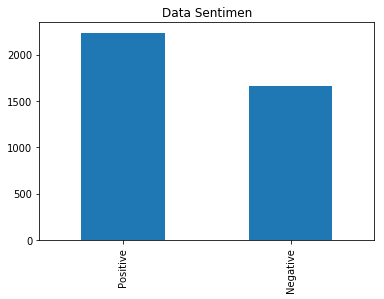

In [45]:
pca = PCA(n_components=2)
pd.value_counts(data_['Class']).plot.bar(title='Data Sentimen')
print(pd.value_counts(data_['Class']))

## Proses Pemodelan

In [10]:
#Import Library
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score

### Input parameter

In [11]:
#Parameter SVM
C = 1.8
gamma = 0.6

## K-Fold Cross Validation 
### jalanin aja dulu

In [36]:
K = 10 #pembagian data uji dan data latih
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score #, precision_score, recall_score
kf= KFold(n_splits=K) 

cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)

akurasi_svm = []

for train_index, test_index in kf.split(X):
    #membagi data latih dan data uji
    X_train, X_test = X[train_index], X[test_index] #pembagian data latih
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Melatih Model 
    mSVM = cSVM.fit(X_train, y_train) #SVM

    #proses prediksi
    P_SVM = mSVM.predict(X_test)

    #menyimpan hasil akurasi tiap iterasi
    akurasi_svm.append(accuracy_score(y_test, P_SVM))
    
rerata_akurasi_svm = sum(akurasi_svm)/len(akurasi_svm)

print("Hasil K-Fold SVM")
print("   Rerata akurasi           :",rerata_akurasi_svm)
print("   Rerata akurasi (round)   :",round(rerata_akurasi_svm,2))
dic1 = {"iterasi ke-":[x+1 for x in range(10)], "akurasi":akurasi_svm}
pd.DataFrame.from_dict(dic1)

Hasil K-Fold SVM
   Rerata akurasi           : 0.9966633709050161 2
   Rerata akurasi (round)   : 1.0


,iterasi ke-,akurasi
0,1,0.997436
1,2,0.994872
2,3,1.000000
3,4,0.989744
4,5,0.997436
5,6,0.997429
6,7,1.000000
7,8,0.989717
8,9,1.000000
9,10,1.000000


In [26]:
rerata_akurasi_svm

0.9966633709050161

# Pengujian
## Proses Confusion Matrix untuk SVM

Positive    2157
Negative    1638
Name: label, dtype: int64

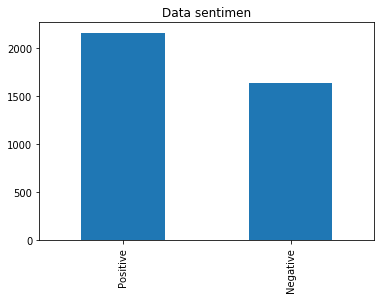

In [35]:
index_train = [x for x in range(3795)]
cm_Y = Y_[index_train]
dc = {"label":cm_Y}
cd = pd.DataFrame(dc, columns=['label'])
pd.value_counts(cd['label']).plot.bar(title='Data sentimen')
pd.value_counts(cd['label'])

In [34]:
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix


index_train = [x for x in range(3795)]
index__test = [x for x in range(3795, 3895)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]
cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test

y_train = cm_Y
y_test = cm_Y_test

class_names = ['Positive', 'Negative']

classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma) #Model SVM
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("SVM")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= cm [0][0]
fn= cm [0][1]
fp= cm [1][0]
tn= cm [1][1]
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("   F-Measure (SVM)")
print("   ----------------")
print("   akurasi   : ", cm_akurasi)
print("   precision : ", cm_precision)
print("   recall    : ", cm_recall)
print("   f-Measure : ", f_measure)

SVM
[[21  0]
 [ 0 79]]
   F-Measure (SVM)
   ----------------
   akurasi   :  1.0
   precision :  1.0
   recall    :  1.0
   f-Measure :  1.0
++++++++++++++++++++



## Menyimpan model

In [18]:
cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
#Melatih Model untuk data secara keseluruhan (X dan Y)
cSVM = cSVM.fit(X, Y) #SVN

#save models
dump(cSVM, 'model/SVM_model_murni.joblib')


NameError: name 'svm' is not defined